In [100]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask.array as da
import matplotlib.pyplot as plt

In [101]:
def lsqfit_md_basic(X,data):
    # assume no NaN values; this is for model results
    # X is nxp covariables; data is nxmxr response variable
    # dimension to do regression on must be 0!
    # calculate linear fit only
    # adapt reshaping code from scipy.signal.detrend
    # put new dimensions at end, except for coefs at front
    data=np.asarray(data)
    dshape = data.shape
    N=dshape[0]
    assert N==len(X) # check correct dimensions
    newdata = np.reshape(data,(N, np.prod(dshape, axis=0) // N)) # // is floor division
    newdata = newdata.copy()  # make sure we have a copy
    b,res,p,svs=np.linalg.lstsq(X,newdata,rcond=None) # res=np.sum((np.dot(X,b)-Y)**2)
    bshp=tuple([2]+list(dshape)[1:])
    b=np.reshape(b,bshp)
    return b

In [102]:
def lsqfit_md_detr(data):
    # linearly detrend along axis 0
    # assume no NaN values; this is for model results
    # adapt reshaping code from scipy.signal.detrend
    # put new dimensions at end
    data=np.asarray(data)
    dshape = data.shape
    N=dshape[0]
    X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
    newdata = np.reshape(data,(N, np.prod(dshape, axis=0) // N)).copy() # // is floor division; ensure copy
    b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
    ydetr=newdata-np.dot(X,b)
    ydetr=np.reshape(ydetr,dshape)
    return ydetr
def lsqfit_md_detrV2(data): # take mean across ensemble members first
    # linearly detrend along axis 0
    # assume no NaN values; this is for model results
    # adapt reshaping code from scipy.signal.detrend
    # put new dimensions at end
    data=np.asarray(data)
    dataM=np.mean(data,axis=1,keepdims=True) # ensemble member must be second dimension (axis=1)
    dshapeM=dataM.shape
    N=dshapeM[0]
    X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
    newdata = np.reshape(dataM,(N, np.prod(dshapeM, axis=0) // N)).copy() # // is floor division; ensure copy
    b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
    yest=np.dot(X,b)
    yest=np.reshape(yest,dshapeM)
    ydetr=data-yest
    return ydetr
def lsqfit_md_detrV3(data): # take mean across ensemble members first
    # linearly detrend along axis 0
    # assume no NaN values; this is for model results
    # adapt reshaping code from scipy.signal.detrend
    # put new dimensions at end
    data=np.asarray(data)
    dshape = data.shape
    N=dshape[0]
    R=dshape[1]
    X=np.concatenate([np.ones((R*N,1)),(np.arange(0,N).reshape((N,1))*np.ones((N,R))).reshape((R*N,-1))],1)
    assert R*N==len(X) # check correct dimensions
    newdata = np.reshape(data,(R*N, np.prod(dshape, axis=0) // (R*N))).copy() # // is floor division; ensure copy
    b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
    ydetr=newdata-np.dot(X,b)
    ydetr=np.reshape(ydetr,dshape)
    return ydetr

In [103]:
workdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/'
mdirC5='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/predictions/cansipsv3_daily/CanESM5'
fnameCanESMjoined=lambda mdir, yyyy, mm, dd, hh: f"{mdir}/joined/cwao_CanESM5.1p1bc-v20240611_hindcast_S{yyyy:04}{mm:02}{dd:02}{hh:02}_ocean_6hr_surface_tso.nc"
fnameCanESMdaily=lambda mdir, yyyy, mm, dd, hh: f"{mdir}/joined/cwao_CanESM5.1p1bc-v20240611_hindcast_S{yyyy:04}{mm:02}{dd:02}{hh:02}_ocean_1d_surface_tso.nc"
fnameCanESMAnom=lambda mdir, climyfirst,climylast,lfirst, llast, mm: f"{mdir}/anom/anom_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_SMon{mm:02}_L_{lfirst:03}_{llast:03}_ocean_1d_surface_tso.nc"
fnameCanESMClim=lambda mdir, climyfirst, climylast, mm: f"{mdir}/clim/clim_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_Mon{mm:02}_ocean_1d_surface_tso.nc"
fnameCanESMAnom=lambda mdir, climyfirst, climylast, yyyy, mm: f"{mdir}/anom/anom_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_SYr{yyyy:04}Mon{mm:02}_ocean_1d_surface_tso.nc"

In [104]:
fnameCanESMAnomByLeadOld=lambda mdir, climyfirst, climylast, ilead, istartlat: f"{mdir}/byLead/anomByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_L{ilead}_j{istartlat}_ocean_1d_surface_tso.nc"
fnameCanESMAnomByLead=lambda mdir, climyfirst, climylast, ilead, istartlat: f"{mdir}/byLead/anomByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_L{ilead:03}_j{istartlat:03}_ocean_1d_surface_tso.nc"
fnameCanESMAnomDetrByLead=lambda mdir, climyfirst, climylast, ilead, istartlat: f"{mdir}/byLeadDetr/anomDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C{climyfirst:04}_{climylast:04}_L{ilead:03}_j{istartlat:03}_ocean_1d_surface_tso.nc"

In [105]:
climyrs=[1993,2023]

In [106]:
ilead=0
jj=0

In [107]:
fin=fnameCanESMAnomByLead(workdir, climyrs[0], climyrs[-1], ilead, jj)

In [108]:
fin

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily//byLead/anomByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j000_ocean_1d_surface_tso.nc'

In [109]:
ff= xr.open_dataset(fin,decode_times=False)#parallel=True,

In [110]:
mod_val=ff.sst_an
mod_val

<xarray.DataArray 'sst_an' (reftime: 378, r: 20, lat: 60, lon: 360)> Size: 1GB
[163296000 values with dtype=float64]
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [111]:
# METHOD 1
data_1=np.asarray(mod_val)
dshape_1 = data_1.shape
N_1=dshape_1[0]
X_1=np.concatenate([np.ones((N_1,1)), np.expand_dims(np.arange(0,N_1),1)],1)
newdata_1 = np.reshape(data_1,(N_1, np.prod(dshape_1, axis=0) // N_1)).copy() # // is floor division; ensure copy
b_1=np.linalg.lstsq(X_1,newdata_1,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
ydetr_1=newdata_1-np.dot(X_1,b_1)
ydetr_1=np.reshape(ydetr_1,dshape_1)
b_1=np.reshape(b_1,(2,dshape_1[1],dshape_1[2],dshape_1[3]))

In [112]:
dshape_1

(378, 20, 60, 360)

In [113]:
# METHOD 2
data_2=np.asarray(mod_val)
dataM_2=np.mean(data_2,axis=1,keepdims=True) # ensemble member must be second dimension (axis=1)
dshapeM_2=dataM_2.shape
N_2=dshapeM_2[0]
X_2=np.concatenate([np.ones((N_2,1)), np.expand_dims(np.arange(0,N_2),1)],1)
newdata_2 = np.reshape(dataM_2,(N_2, np.prod(dshapeM_2, axis=0) // N_2)).copy() # // is floor division; ensure copy
b_2=np.linalg.lstsq(X_2,newdata_2,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
yest_2=np.dot(X_2,b_2)
yest_2=np.reshape(yest_2,dshapeM_2)
ydetr_2=data_2-yest_2
b_2=np.reshape(b_2,(2,1,dshapeM_2[2],dshapeM_2[3]))

In [114]:
data_2.shape

(378, 20, 60, 360)

In [115]:
# METHOD 3
data_3=np.asarray(mod_val).copy()
dshape_3 = data_3.shape
for ii in range(1,dshape_3[1]):
    data_3[:,ii,:,:]=data_3[:,0,:,:]
N_3=dshape_3[0]
R_3=dshape_3[1]
X_3=np.concatenate([np.ones((R_3*N_3,1)),(np.arange(0,N_3).reshape((N_3,1))*np.ones((N_3,R_3))).reshape((R_3*N_3,-1))],1)
newdata_3 = np.reshape(data_3,(R_3*N_3, np.prod(dshape_3, axis=0) // (R_3*N_3))).copy() # // is floor division; ensure copy
b_3=np.linalg.lstsq(X_3,newdata_3,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
ydetr_3=newdata_3-np.dot(X_3,b_3)
ydetr_3=np.reshape(ydetr_3,dshape_3)
b_3=np.reshape(b_3,(2,1,dshape_3[2],dshape_3[3]))

In [118]:
# METHOD 3
data_3=np.asarray(mod_val).copy()
dshape_3 = data_3.shape
N_3=dshape_3[0]
R_3=dshape_3[1]
X_3=np.concatenate([np.ones((R_3*N_3,1)),(np.arange(0,N_3).reshape((N_3,1))*np.ones((N_3,R_3))).reshape((R_3*N_3,-1))],1)
newdata_3 = np.reshape(data_3,(R_3*N_3, np.prod(dshape_3, axis=0) // (R_3*N_3))).copy() # // is floor division; ensure copy
b_3=np.linalg.lstsq(X_3,newdata_3,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
ydetr_3=newdata_3-np.dot(X_3,b_3)
ydetr_3=np.reshape(ydetr_3,dshape_3)
b_3=np.reshape(b_3,(2,1,dshape_3[2],dshape_3[3]))

In [119]:
b_2.shape,b_3.shape

((2, 1, 60, 360), (2, 1, 60, 360))

In [121]:
np.nanmax(np.abs(b_2-b_3))

np.float64(1.3322676295501878e-15)

In [31]:
b_1.shape

(2, 432000)

In [44]:
np.shape(np.dot(X_3,b_3))

(7560, 21600)

In [45]:
np.shape(newdata_3)

(7560, 21600)

In [37]:
b_2.shape

(2, 1, 60, 360)

In [36]:
b_3.shape

(2, 1, 60, 360)

In [35]:
b_1.shape

(2, 20, 60, 360)

In [39]:
b_1[1,0,-1,100], b_2[1,0,-1,100],b_3[1,0,-1,100]

(np.float64(0.0007980732554402041),
 np.float64(0.000772353211959616),
 np.float64(0.0007980732554402035))

In [ ]:
plt.plot(b_2,'c.')
plt.plot(ff.sst_an[:,:,-1,100]-out2[:,:,-1,100],'m.');

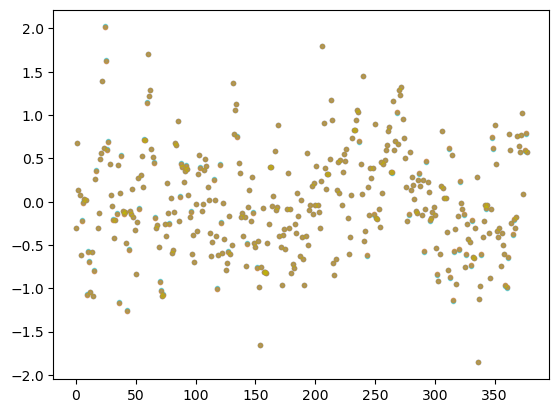

In [46]:
plt.plot(ydetr_1[:,0,-1,100],'c.',alpha=.5)
plt.plot(ydetr_2[:,0,-1,100],'m.',alpha=.5)
plt.plot(ydetr_3[:,0,-1,100],'y.',alpha=.5)

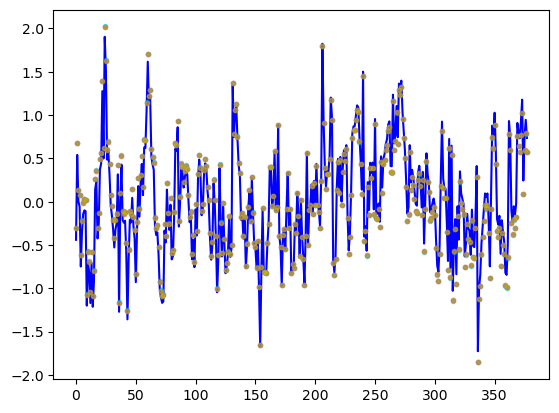

In [52]:
plt.plot(ff.sst_an[:,0,-1,100],'b-')
plt.plot(ydetr_1[:,0,-1,100],'c.',alpha=.5)
plt.plot(ydetr_2[:,0,-1,100],'m.',alpha=.5)
plt.plot(ydetr_3[:,0,-1,100],'y.',alpha=.5)

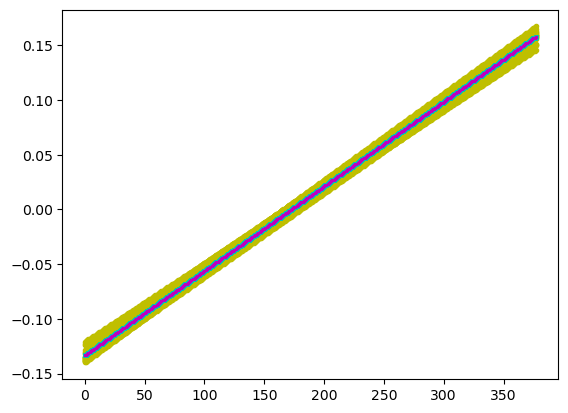

In [51]:

plt.plot(ff.sst_an[:,:,-1,100]-ydetr_1[:,:,-1,100],'y.')
plt.plot(ff.sst_an[:,:,-1,100]-ydetr_2[:,:,-1,100],'c.',ms=5)
plt.plot(ff.sst_an[:,:,-1,100]-ydetr_3[:,:,-1,100],'m.',ms=2);

In [22]:
####test new code
# linearly detrend along axis 0
# assume no NaN values; this is for model results
# adapt reshaping code from scipy.signal.detrend
# put new dimensions at end
data0=np.asarray(mod_val)
data=np.mean(data,axis=1,keepdims=True) # ensemble member must be second dimension (axis=1)

In [23]:
data.shape, data0.shape

((378, 1, 60, 360), (378, 20, 60, 360))

In [24]:
dshape = data.shape
N=dshape[0]
X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
X.shape

(378, 2)

In [25]:
newdata = np.reshape(data,(N, np.prod(dshape, axis=0) // N)).copy() # // is floor division; ensure copy
newdata.shape

(378, 21600)

In [26]:
b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
b.shape

(2, 21600)

In [27]:
yest=np.dot(X,b)
yest.shape

(378, 21600)

In [28]:
yest=np.reshape(yest,dshape)
yest.shape

(378, 1, 60, 360)

In [31]:
ydetr=data0-yest
ydetr.shape,data0.shape,yest.shape

((378, 20, 60, 360), (378, 20, 60, 360), (378, 1, 60, 360))

In [39]:
test=lsqfit_md_detrV2(mod_val)

In [40]:
np.nanmax(np.abs(test-ydetr))

np.float64(0.0)

In [56]:

data=np.asarray(mod_val)
dshape = data.shape
N=dshape[0]
R=dshape[1]
X=np.concatenate([(np.arange(0,N).reshape((N,1))*np.ones((N,R))).reshape((R*N,-1)), np.expand_dims(np.arange(0,R*N),1)],1)
assert R*N==len(X) # check correct dimensions
newdata = np.reshape(data,(R*N, np.prod(dshape, axis=0) // (R*N))).copy() # // is floor division; ensure copy
b=np.linalg.lstsq(X,newdata,rcond=None)[0] # res=np.sum((np.dot(X,b)-Y)**2)
yest=np.dot(X,b)
yest=np.reshape(yest,(R*N,dshape[2],dshape[3])).reshape((N,R,dshape[2],dshape[3]))
ydetr2=data-yest

In [57]:
np.nanmax(np.abs(ydetr2-ydetr))

np.float64(0.8935062900942339)

In [26]:
out=lsqfit_md_detr(ff.sst_an)

In [57]:
out1=lsqfit_md_detr(ff.sst_an)
out2=lsqfit_md_detrV2(ff.sst_an)
out3=lsqfit_md_detrV3(ff.sst_an)

In [63]:
#j,i=-1,100
j,i=-20,100

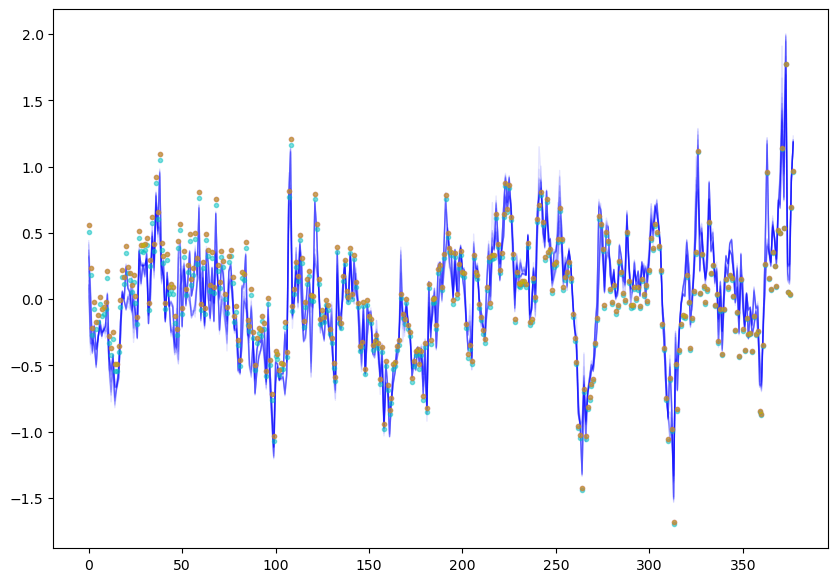

In [73]:
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.plot(ff.sst_an[:,:,j,i],'b-',lw=1,alpha=.1)
ax.plot(out1[:,0,j,i],'c.',alpha=.5)
ax.plot(out2[:,0,j,i],'m.',alpha=.5)
ax.plot(out3[:,0,j,i],'y.',alpha=.5)

In [94]:
import matplotlib as mpl
colormap = plt.cm.jet #or any other colormap
normalize = mpl.colors.Normalize(vmin=0, vmax=19)

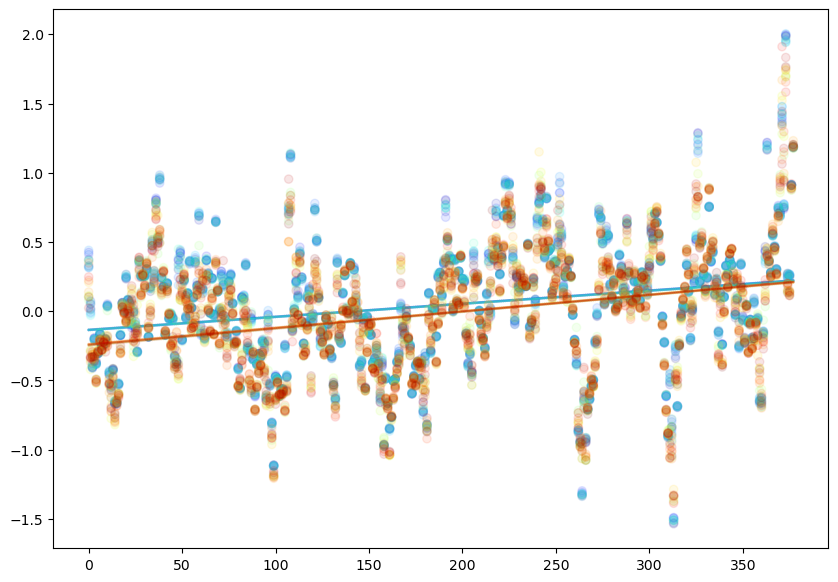

In [98]:
L=ff.sst_an.shape[0]
fig,ax=plt.subplots(1,1,figsize=(10,7))
for ii in range(0,20):
    ax.scatter(np.arange(0,L),ff.sst_an[:,ii,j,i],c=ii*np.ones((1,L)),cmap=colormap,norm=normalize,alpha=.1)
    ax.scatter(np.arange(0,L),ff.sst_an[:,ii,j,i]-out1[:,ii,j,i],c=ii*np.ones((1,L)),s=1,cmap=colormap,norm=normalize,alpha=.1,)

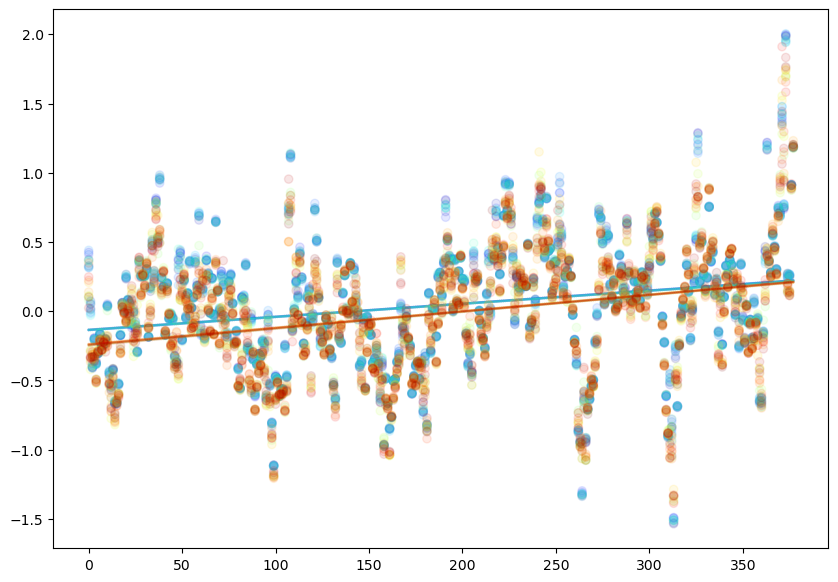

In [99]:
L=ff.sst_an.shape[0]
fig,ax=plt.subplots(1,1,figsize=(10,7))
for ii in range(0,20):
    ax.scatter(np.arange(0,L),ff.sst_an[:,ii,j,i],c=ii*np.ones((1,L)),cmap=colormap,norm=normalize,alpha=.1)
    ax.scatter(np.arange(0,L),ff.sst_an[:,ii,j,i]-lsqfit_md_detr(ff.sst_an[:,ii,j,i]),c=ii*np.ones((1,L)),s=1,cmap=colormap,norm=normalize,alpha=.1,)

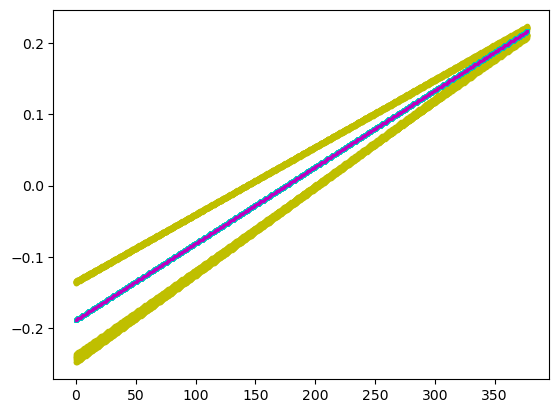

In [65]:
plt.plot(ff.sst_an[:,:,j,i]-out1[:,:,j,i],'y.')
plt.plot(ff.sst_an[:,:,j,i]-out2[:,:,j,i],'c.',ms=5)
plt.plot(ff.sst_an[:,:,j,i]-out3[:,:,j,i],'m.',ms=2);